# Kolokwium
## Twitter airline sentiment


In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing Data
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# WordCloud
#!pip install wordcloud
from wordcloud import WordCloud
from PIL import Image

#
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
df = pd.read_csv('Data/tweets_airline.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<AxesSubplot:xlabel='airline', ylabel='count'>

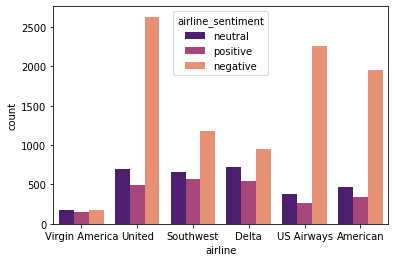

In [5]:
print(df['airline_sentiment'].value_counts())
sns.countplot(data = df, x ="airline", hue = "airline_sentiment", palette = 'magma' )

In [6]:
pd.DataFrame(df[['airline_sentiment','airline']].value_counts(),columns=['Rated']).head(30)

Rated
airline_sentiment airline              
negative          United           2633
                  US Airways       2263
                  American         1960
                  Southwest        1186
                  Delta             955
neutral           Delta             723
                  United            697
                  Southwest         664
positive          Southwest         570
                  Delta             544
                  United            492
neutral           American          463
                  US Airways        381
positive          American          336
                  US Airways        269
negative          Virgin America    181
neutral           Virgin America    171
positive          Virgin America    152

<AxesSubplot:ylabel='negativereason'>

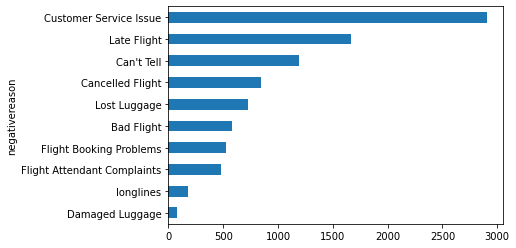

In [7]:
df.groupby('negativereason')['negativereason'].count().sort_values(ascending=True).plot.barh()

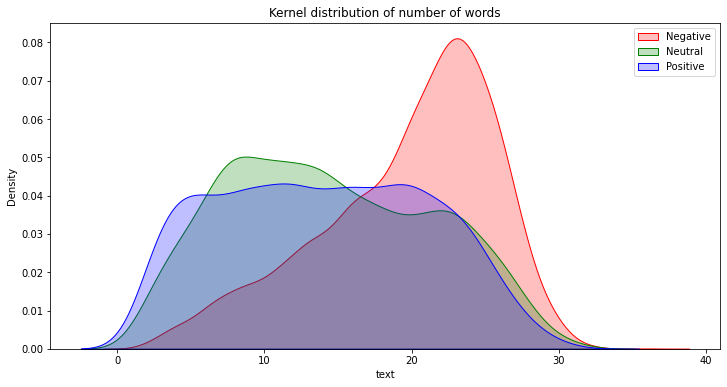

In [8]:
num_neg = df[df['airline_sentiment']=='negative']['text'].apply(lambda x: len(x.split()))
num_neu = df[df['airline_sentiment']=='neutral']['text'].apply(lambda x: len(x.split()))
num_pos = df[df['airline_sentiment']=='positive']['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.kdeplot(num_neg, shade=True, color = 'r').set_title('Kernel distribution of number of words')
sns.kdeplot(num_neu, shade=True, color = 'g')
sns.kdeplot(num_pos, shade=True, color = 'b')

plt.legend(labels=['Negative', 'Neutral','Positive'])

### Utility Functions

<ul>
    <li> clean_text() - set lowercase, remove numbers, html tags, special characters </li>
    <li> delete_stop_words()  - remove stop words</li>
    <li> stemming() - stemming </li>
    <li> stemming_list() - stemming return list</li>
    <li> text_tokenizer() - text tokenize, use previous functions (clean_text, stop_words, stemming), removing words with less than 3 letters</li>
    <li> cleaning_for_visualization() - preprocessing to visualization data </li>
    <li> word_count() - counting occurance of each word </li>
</ul>

In [9]:
def clean_text(text: str) -> str:
    emoticons = re.findall(r'[:|;][-]?[)|(|<>]', text)
    text_low = text.lower()
    text_without_number = re.sub(r'\d', '', text_low)
    text_without_html = re.sub(r'<.*?>', '', text_without_number)
    text_without_punc_marks = re.sub(r'\W(?<!\s)', '', text_without_html)
    text_without_white_space = text_without_punc_marks.strip()
    text_done = text_without_white_space + ' '.join(emoticons)
    return text_done


def delete_stop_words(text: str) -> list[str]:
    stop_words = stopwords.words("english")
    return [w for w in text if not w.lower() in stop_words]


def stemming(word: str) -> str:
    ps = PorterStemmer()
    return ps.stem(word)

def stemming_list(text: str) -> list:
    tokens = word_tokenize(text)
    ps = PorterStemmer()
    stem_list = []
    for word in tokens:
        stem_list.append(ps.stem(word))
    return stem_list


def text_tokenizer(text: str):
    clened = clean_text(text)
    tokens = word_tokenize(clened)
    without_stopwords = delete_stop_words(tokens)

    return [stemming(w) for w in without_stopwords if len(w) > 3]

def cleaning_for_visualization(text: str) -> str:
    text = clean_text(text)
    stem_words = stemming_list(text)
    wordlist = delete_stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return " ".join(new_wordlist)

def word_count(text: str) -> dict:
    word_tokens = word_tokenize(text)
    counts = dict()
    for word in word_tokens:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts


**Function  to vectorization**
<ul>
<li>mostfrequently_occurring - return 10 most frequently tokens using CountVectorizer (barh and PrettyTable) </li>
<li>most_importatnt -  return 10 most important tokens using TfidfVectorizer (barh and PrettyTable) </li>
</ul>

In [67]:
def mostfrequently_occurring(sentiment,text: str):
    count_vectorizer = CountVectorizer(tokenizer=text_tokenizer)
    x_transform = count_vectorizer.fit_transform(text)
    gf = count_vectorizer.get_feature_names_out(text)
    summ = sum(x_transform.toarray())
    i = np.argpartition(summ, -10)[-10:]
    plt.figure(figsize=(12,6))
    plt.barh(gf[i], summ[i], color='cornflowerblue')
    plt.title('Most Frequently tokens of ' + sentiment)
    plt.ylabel('Token')
    plt.xlabel('Liczba wystąpień ')
    plt.show()
    columns = ['Token', 'Liczba wystąpień ']
    pt = PrettyTable()
    pt.add_column(columns[0], gf[i])
    pt.add_column(columns[1], summ[i])
    pt.sortby = columns[1]
    print(pt)


def most_importatnt(sentiment, text: str):
    tfid_vectorizer = TfidfVectorizer(tokenizer=text_tokenizer)
    tfid_x_transform = tfid_vectorizer.fit_transform(text)
    tgf = tfid_vectorizer.get_feature_names_out(text)
    tsum = sum(tfid_x_transform.toarray())
    ti = np.argpartition(tsum, -10)[-10:]
    plt.figure(figsize=(12,6))
    plt.barh(tgf[ti], tsum[ti], color='mediumturquoise')
    plt.title('Najważniejsze tokeny TF-IDF' + sentiment)
    plt.ylabel('Token')
    plt.xlabel('TFIDF')
    plt.show()
    col = ['Token', 'TF-IDF']
    tpt = PrettyTable()
    tpt.add_column(col[0], tgf[ti])
    tpt.add_column(col[1], tsum[ti])
    tpt.sortby = col[1]
    print(tpt)

### WordClouds

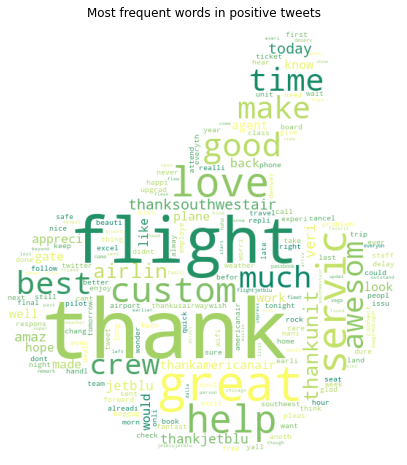

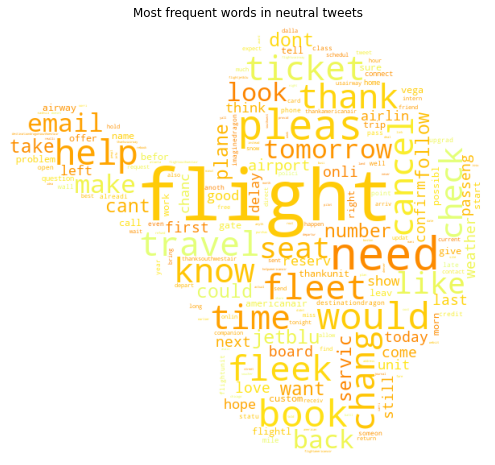

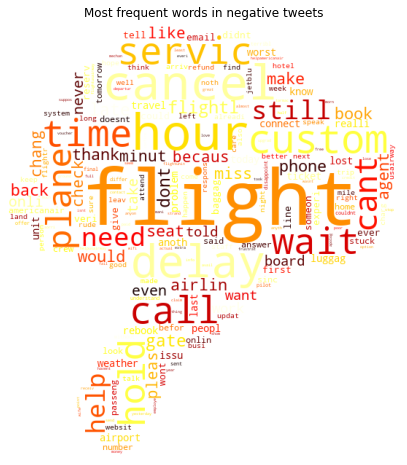

In [63]:
data_vizualization = df[['text','airline_sentiment']].copy()
data_vizualization['text'] = data_vizualization['text'].apply(cleaning_for_visualization)
postive_mask = np.array(Image.open('Data/positive.png'))
neutral_mask = np.array(Image.open('Data/neutral.png'))
negative_mask = np.array(Image.open('Data/negative.png'))

mask = [postive_mask, neutral_mask, negative_mask]
color = ['summer', 'Wistia', 'hot']
sentiment = ['positive', 'neutral', 'negative']

for sentiment, colormap, masks in zip(sentiment, color, mask):
    text = data_vizualization.query('airline_sentiment == @sentiment')['text'].str.cat()
    plt.figure(figsize=[10, 8])
    wc = WordCloud(background_color="white", colormap=colormap, mask = masks).generate_from_frequencies(word_count(text))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Most frequent words in {sentiment} tweets")
    plt.show()

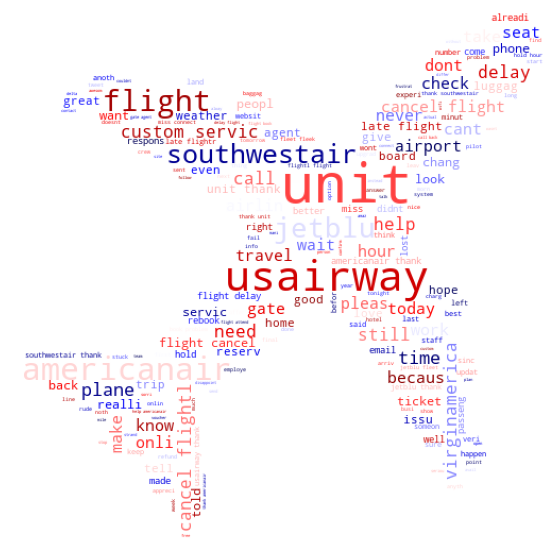

In [13]:
fly_mask = np.array(Image.open('Data/airplane.jpg'))
words = ' '.join(df['text'])
clear = cleaning_for_visualization(words)
wordcloud =WordCloud(
                      colormap = 'seismic',
                      background_color='white',
                      mask = fly_mask,
                     ).generate(clear)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Vectorization CountVectorizer, TfidfVectorizer

Top 10 Najczęściej występujących tokenów


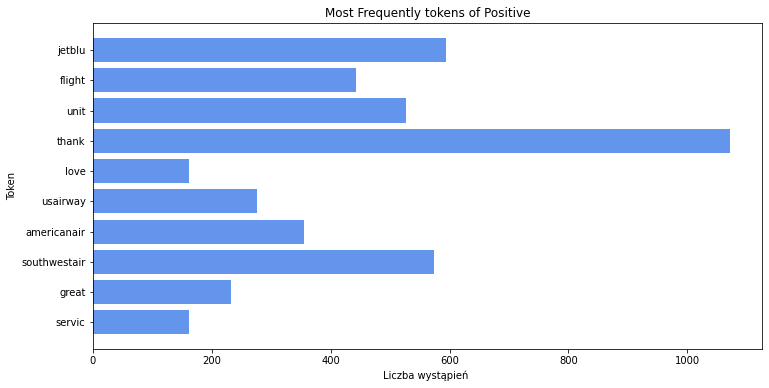

+--------------+-------------------+
|    Token     | Liczba wystąpień  |
+--------------+-------------------+
|     love     |        162        |
|    servic    |        162        |
|    great     |        233        |
|   usairway   |        277        |
| americanair  |        355        |
|    flight    |        442        |
|     unit     |        527        |
| southwestair |        574        |
|    jetblu    |        594        |
|    thank     |        1072       |
+--------------+-------------------+


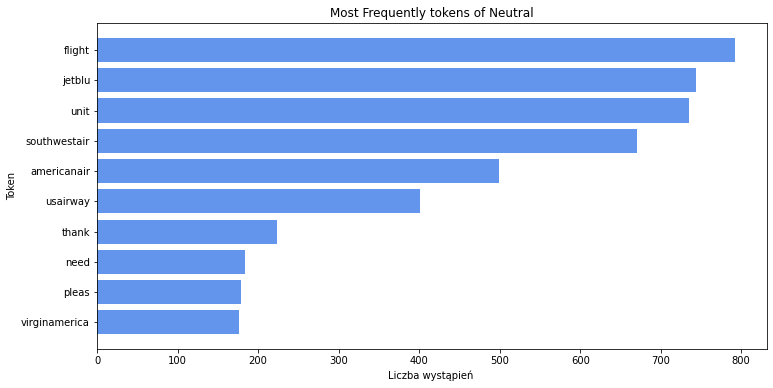

+---------------+-------------------+
|     Token     | Liczba wystąpień  |
+---------------+-------------------+
| virginamerica |        176        |
|     pleas     |        179        |
|      need     |        184        |
|     thank     |        224        |
|    usairway   |        401        |
|  americanair  |        499        |
|  southwestair |        670        |
|      unit     |        735        |
|     jetblu    |        744        |
|     flight    |        792        |
+---------------+-------------------+


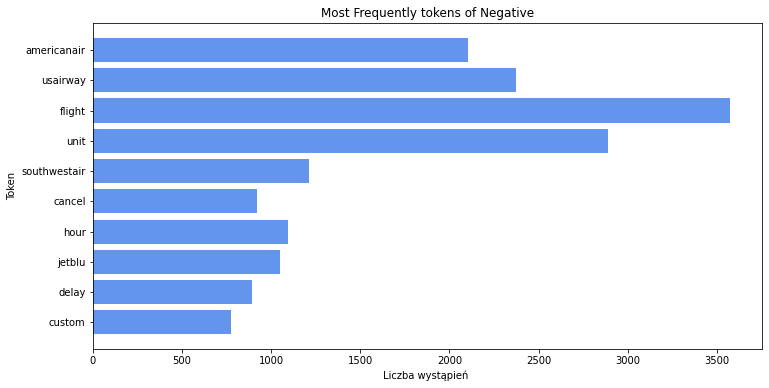

+--------------+-------------------+
|    Token     | Liczba wystąpień  |
+--------------+-------------------+
|    custom    |        775        |
|    delay     |        892        |
|    cancel    |        920        |
|    jetblu    |        1053       |
|     hour     |        1097       |
| southwestair |        1212       |
| americanair  |        2104       |
|   usairway   |        2374       |
|     unit     |        2890       |
|    flight    |        3574       |
+--------------+-------------------+
10 Najważniejszych tokenów


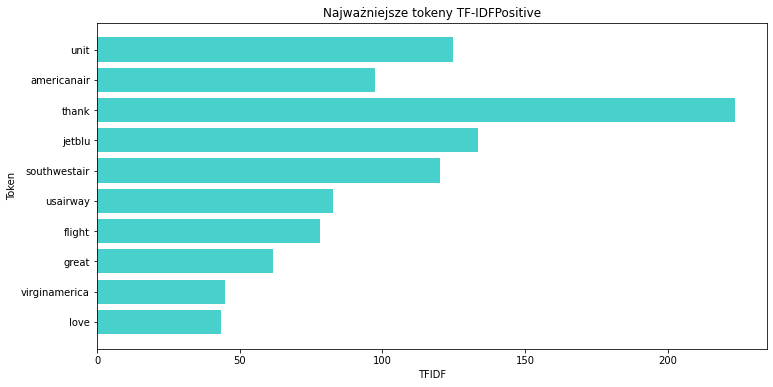

+---------------+--------------------+
|     Token     |       TF-IDF       |
+---------------+--------------------+
|      love     | 43.31704464747026  |
| virginamerica | 44.81597145510417  |
|     great     | 61.58758034662113  |
|     flight    | 78.06504427993981  |
|    usairway   | 82.75196814985753  |
|  americanair  | 97.47258130458987  |
|  southwestair | 120.2256769025382  |
|      unit     | 124.76760522185448 |
|     jetblu    | 133.4940079970606  |
|     thank     | 223.44037765743352 |
+---------------+--------------------+


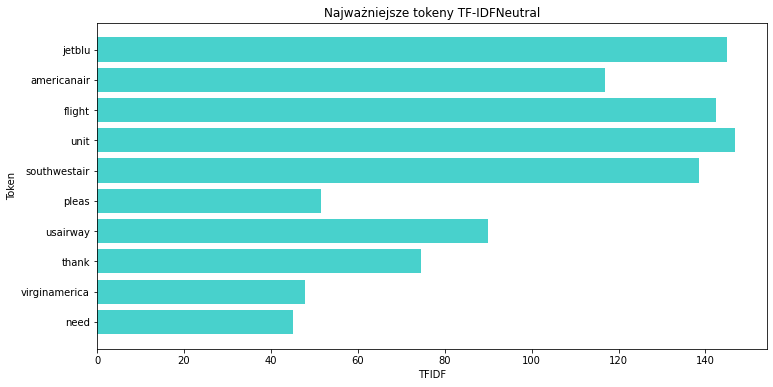

+---------------+--------------------+
|     Token     |       TF-IDF       |
+---------------+--------------------+
|      need     | 45.03139255350472  |
| virginamerica | 47.89915513171203  |
|     pleas     | 51.644336440863775 |
|     thank     | 74.65117912701581  |
|    usairway   | 89.96828948261201  |
|  americanair  | 116.88115001844437 |
|  southwestair | 138.5222927812585  |
|     flight    | 142.48375967380795 |
|     jetblu    | 144.93781868769685 |
|      unit     | 146.75703942489892 |
+---------------+--------------------+


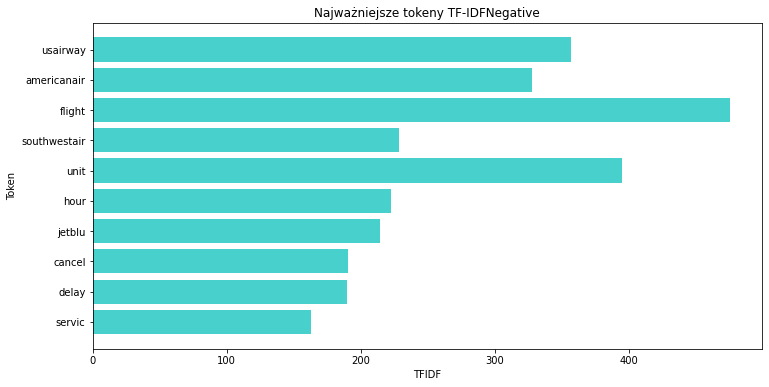

+--------------+--------------------+
|    Token     |       TF-IDF       |
+--------------+--------------------+
|    servic    | 162.5643875034571  |
|    delay     | 189.79606840190218 |
|    cancel    | 190.61584024892028 |
|    jetblu    | 214.13644735467156 |
|     hour     | 222.77505630849387 |
| southwestair | 228.63773025335513 |
| americanair  | 327.8598020169219  |
|   usairway   |  356.93092694276   |
|     unit     | 394.6523673193362  |
|    flight    | 475.6254163467391  |
+--------------+--------------------+


In [68]:
positive_data = df[df['airline_sentiment']=='positive']['text']
neutral_data = df[df['airline_sentiment']=='neutral']['text']
negative_data = df[df['airline_sentiment']=='negative']['text']

print('Top 10 Najczęściej występujących tokenów')
mostfrequently_occurring('Positive', positive_data)
mostfrequently_occurring('Neutral', neutral_data)
mostfrequently_occurring('Negative', negative_data)

print('10 Najważniejszych tokenów')
most_importatnt('Positive', positive_data)
most_importatnt('Neutral', neutral_data)
most_importatnt('Negative', negative_data)

### Classification

<ul>
<li> DecisionTreeClassifier </li>
<li> RandomForestClassifier </li>
<li> Support Vector Machine </li>
<li> KNeighborsClassifier </li>
<li> AdaBoost </li>
<li> BaggingClassifier </li>
<li> Logistic Regression </li>
</ul>

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.3, random_state=1, shuffle = True, stratify = df['airline_sentiment'])


In [16]:
best = {}

In [17]:
vectorizer = CountVectorizer(tokenizer=text_tokenizer)
X_train_transform = vectorizer.fit_transform(X_train)
X_test_transform = vectorizer.transform(X_test)

**DecisionTreeClassifier**

DecisionTreeClassifier Dokładność w danych uczących : 0.994
DecisionTreeClassifier Dokładność w danych testowych: 0.703
DecisionTreeClassifier Model: 
              precision    recall  f1-score   support

    negative       0.81      0.80      0.81      2753
     neutral       0.47      0.53      0.50       930
    positive       0.60      0.54      0.57       709

    accuracy                           0.70      4392
   macro avg       0.63      0.62      0.63      4392
weighted avg       0.71      0.70      0.70      4392



Text(0.5, 1.0, 'Decision Tree Classifier - Confusion Matrix')

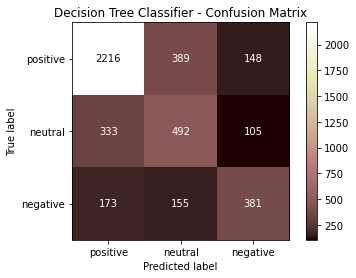

In [44]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train_transform, Y_train)
tree_predict = tree.predict(X_test_transform)
print('DecisionTreeClassifier Dokładność w danych uczących : {:.3f}'.format(tree.score(X_train_transform, Y_train)))
print('DecisionTreeClassifier Dokładność w danych testowych: {:.3f}'.format(tree.score(X_test_transform, Y_test)))
best['DecisionTreeClassifier'] = tree.score(X_test_transform, Y_test)
print(f'DecisionTreeClassifier Model: ')
print(classification_report(Y_test, tree_predict))

tree_cm = confusion_matrix(Y_test, tree_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('Decision Tree Classifier - Confusion Matrix')

**RandomForestClassifier**

RandomForestClassifier Dokładność w danych uczących: 0.961
RandomForestClassifier Dokładność w danych testowych: 0.714
RandomForestClassifier Model 
               precision    recall  f1-score   support

    negative       0.79      0.85      0.82      2753
     neutral       0.50      0.46      0.48       930
    positive       0.64      0.51      0.57       709

    accuracy                           0.71      4392
   macro avg       0.64      0.61      0.62      4392
weighted avg       0.70      0.71      0.71      4392



Text(0.5, 1.0, 'Random Forest Classifier - Confusion Matrix')

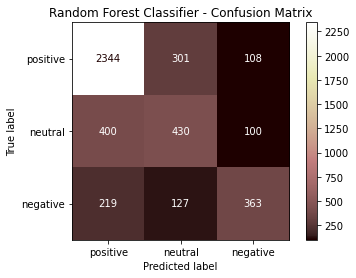

In [45]:
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest = forest.fit(X_train_transform, Y_train)
forest_predict = forest.predict(X_test_transform)
print('RandomForestClassifier Dokładność w danych uczących: {:.3f}'.format(forest.score(X_train_transform, Y_train)))
print('RandomForestClassifier Dokładność w danych testowych: {:.3f}'.format(forest.score(X_test_transform, Y_test)))
best['RandomForestClassifier'] = forest.score(X_test_transform, Y_test)
print(f'RandomForestClassifier Model \n {classification_report(Y_test, forest_predict)}')

forest_cm = confusion_matrix(Y_test, forest_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=forest_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('Random Forest Classifier - Confusion Matrix')

**Support Vector Machine**

SVM Dokładność w danych uczących: 0.910
SVM Dokładność w danych testowych: 0.775
SVM Model 
               precision    recall  f1-score   support

    negative       0.81      0.92      0.86      2753
     neutral       0.63      0.50      0.56       930
    positive       0.76      0.55      0.64       709

    accuracy                           0.78      4392
   macro avg       0.73      0.66      0.69      4392
weighted avg       0.77      0.78      0.76      4392



Text(0.5, 1.0, 'SVM - Confusion Matrix')

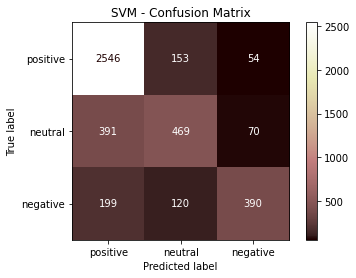

In [46]:
svml = SVC()
svml = svml.fit(X_train_transform, Y_train)
svm_predict = svml.predict(X_test_transform)
print('SVM Dokładność w danych uczących: {:.3f}'.format(svml.score(X_train_transform, Y_train)))
print('SVM Dokładność w danych testowych: {:.3f}'.format(svml.score(X_test_transform, Y_test)))
best['SVM'] = svml.score(X_test_transform, Y_test)
print(f'SVM Model \n {classification_report(Y_test, svm_predict)}')

svml_cm = confusion_matrix(Y_test, svm_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=svml_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('SVM - Confusion Matrix')

**KNeighborsClassifier**

KNeighborsClassifier Dokładność w danych uczących: 0.647
KNeighborsClassifier Dokładność w danych testowych: 0.510
KNeighborsClassifier Model 
               precision    recall  f1-score   support

    negative       0.81      0.46      0.59      2753
     neutral       0.28      0.69      0.40       930
    positive       0.59      0.45      0.51       709

    accuracy                           0.51      4392
   macro avg       0.56      0.54      0.50      4392
weighted avg       0.67      0.51      0.54      4392



Text(0.5, 1.0, 'KNeighbors Classifier - Confusion Matrix')

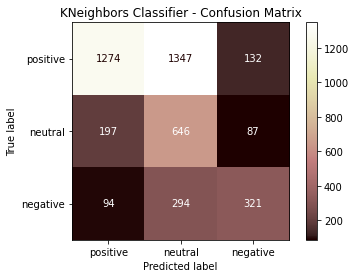

In [47]:
from sklearn.neighbors import KNeighborsClassifier
kneighbors = KNeighborsClassifier()
kneighbors = kneighbors.fit(X_train_transform, Y_train)
kneighbors_predict = kneighbors.predict(X_test_transform)
print('KNeighborsClassifier Dokładność w danych uczących: {:.3f}'.format(kneighbors.score(X_train_transform, Y_train)))
print('KNeighborsClassifier Dokładność w danych testowych: {:.3f}'.format(kneighbors.score(X_test_transform, Y_test)))
best['KNeighborsClassifier'] = kneighbors.score(X_test_transform, Y_test)
print(f'KNeighborsClassifier Model \n {classification_report(Y_test, kneighbors_predict)}')

kneighbors_cm = confusion_matrix(Y_test, kneighbors_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=kneighbors_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('KNeighbors Classifier - Confusion Matrix')

**AdaBoost**

AdaBoostClassifier Dokładność w danych uczących: 0.733
AdaBoostClassifier Dokładność w danych testowych: 0.725
AdaBoostClassifier Model 
               precision    recall  f1-score   support

    negative       0.78      0.88      0.83      2753
     neutral       0.52      0.37      0.43       930
    positive       0.67      0.58      0.62       709

    accuracy                           0.72      4392
   macro avg       0.66      0.61      0.63      4392
weighted avg       0.71      0.72      0.71      4392



Text(0.5, 1.0, 'Ada Boost Classifier - Confusion Matrix')

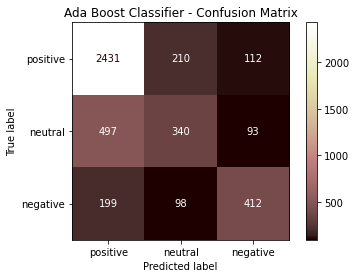

In [48]:
ada = AdaBoostClassifier()
ada = ada.fit(X_train_transform, Y_train)
ada_predict = ada.predict(X_test_transform)
print('AdaBoostClassifier Dokładność w danych uczących: {:.3f}'.format(ada.score(X_train_transform, Y_train)))
print('AdaBoostClassifier Dokładność w danych testowych: {:.3f}'.format(ada.score(X_test_transform, Y_test)))
best['AdaBoostClassifier'] = ada.score(X_test_transform, Y_test)
print(f'AdaBoostClassifier Model \n {classification_report(Y_test, ada_predict)}')

ada_cm = confusion_matrix(Y_test, ada_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=ada_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('Ada Boost Classifier - Confusion Matrix')

BaggingClassifier Dokładność w danych uczących: 0.976
BaggingClassifier Dokładność w danych testowych: 0.730
BaggingClassifier Model 
               precision    recall  f1-score   support

    negative       0.81      0.86      0.84      2753
     neutral       0.52      0.50      0.51       930
    positive       0.64      0.53      0.58       709

    accuracy                           0.73      4392
   macro avg       0.66      0.63      0.64      4392
weighted avg       0.72      0.73      0.72      4392



Text(0.5, 1.0, 'Bagging Classifier - Confusion Matrix')

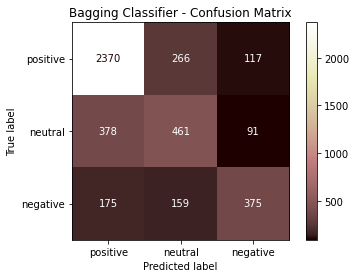

In [49]:
bagg = BaggingClassifier()
bagg = bagg.fit(X_train_transform, Y_train)
bagg_predict = bagg.predict(X_test_transform)
print('BaggingClassifier Dokładność w danych uczących: {:.3f}'.format(bagg.score(X_train_transform, Y_train)))
print('BaggingClassifier Dokładność w danych testowych: {:.3f}'.format(bagg.score(X_test_transform, Y_test)))
best['BaggingClassifier'] = bagg.score(X_test_transform, Y_test)
print(f'BaggingClassifier Model \n {classification_report(Y_test, bagg_predict)}')

bagg_cm = confusion_matrix(Y_test, bagg_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=bagg_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('Bagging Classifier - Confusion Matrix')

**Logistic Regression**

LogisticRegression Dokładność w danych uczących: 0.920
LogisticRegression Dokładność w danych testowych: 0.780
Logistic Regression Model 
               precision    recall  f1-score   support

    negative       0.84      0.89      0.86      2753
     neutral       0.61      0.57      0.59       930
    positive       0.73      0.64      0.68       709

    accuracy                           0.78      4392
   macro avg       0.73      0.70      0.71      4392
weighted avg       0.77      0.78      0.78      4392



Text(0.5, 1.0, 'Logistic Regression - Confusion Matrix')

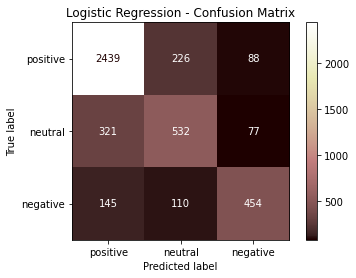

In [50]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_transform, Y_train)

lon_reg_predict = log_reg.predict(X_test_transform)
print('LogisticRegression Dokładność w danych uczących: {:.3f}'.format(log_reg.score(X_train_transform, Y_train)))
print('LogisticRegression Dokładność w danych testowych: {:.3f}'.format(log_reg.score(X_test_transform, Y_test)))
best['LogisticRegression'] = log_reg.score(X_test_transform, Y_test)
print(f'Logistic Regression Model \n {classification_report(Y_test, lon_reg_predict)}')

lon_reg_cm = confusion_matrix(Y_test, lon_reg_predict)
pltc = ConfusionMatrixDisplay(confusion_matrix=lon_reg_cm, display_labels=['positive', 'neutral', 'negative'])
pltc.plot(cmap = 'pink')
pltc.ax_.set_title('Logistic Regression - Confusion Matrix')

In [51]:
win = pd.DataFrame.from_dict(best, orient='index', columns=['Wynik'])
win.sort_values(by = 'Wynik', ascending=False)

,Wynik
LogisticRegression,0.779827
SVM,0.775273
BaggingClassifier,0.729964
AdaBoostClassifier,0.724727
RandomForestClassifier,0.714253
DecisionTreeClassifier,0.703324
KNeighborsClassifier,0.510246


Jak widać, regresja logistyczna okazała się zwycięzcą.
Dokładność wszystkich poprawnie sklasyfikowanych tweetów z sentymentem wyniosła 78%.

**Precision**
84% tweetów, które model przewidział jako *negatywne*, okazało się poprawnych.
61% tweetów, które model przewidział jako *neutralne*, okazało się poprawnych.
73% tweetów, które model przewidział jako *pozytywne*, okazało się poprawnych.

**Recall**

Spośród wszystkich tweetów, które rzeczywiście zostały zaklasyfikowane jako
*negatywny*, model przewidział wynik poprawnie tylko dla 89% tych tweetów.

Spośród wszystkich tweetów, które zostały zaklasyfikowane jako
*neutralny*, model przewidział wynik poprawnie tylko dla 57% tych tweetów.

Spośród wszystkich tweetów, które zostały zaklasyfikowane jako
*pozytywny*, model przewidział wynik poprawnie tylko dla 64% tych tweetów.


**F1 Score**
Wynik F1 równy 0,88 wskazuje, że model dobrze przewiduje wszystkie obserwacje o *negatywnym* sentymencie.
Wynik F1 równy 0,59 wskazuje, że model przewiduje, że obserwacje *neutralne* nastroje są na niezłym poziomie.
Wynik F1 równy 0,68 wskazuje, że model przewiduje, że obserwacje *pozytywnego* sentymentu są na niezłym poziomie.
